In [1]:
# Gerekli paketlerin yüklenmesi
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
sns.set_theme()
from skimage import exposure
from skimage import io
import cv2
import random
from scipy.ndimage import zoom

In [2]:
!git clone https://github.com/hardik0/AI-for-Medicine-Specialization
%cd AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis/


Cloning into 'AI-for-Medicine-Specialization'...
remote: Enumerating objects: 1601, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 1601 (delta 9), reused 2 (delta 0), pack-reused 1573 (from 1)
Receiving objects: 100% (1601/1601), 720.36 MiB | 32.50 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Updating files: 100% (1497/1497), done.
/content/AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis


In [3]:
%ls nih/

densenet.hdf5  images_small/  pretrained_model.h5  test.csv  train-small.csv  valid-small.csv


In [4]:
# Eğitim verilerini içeren cvs dosya okuması
train_df = pd.read_csv("nih/train-small.csv")
# İlk 5 satırın yazdırılması
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in this data frame')

train_df.head()

There are 1000 rows and 16 columns in this data frame


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [5]:
# Her sütunun veri türüne ve null değerlerin mevcut olup olmadığı incelenmesi
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               1000 non-null   object
 1   Atelectasis         1000 non-null   int64 
 2   Cardiomegaly        1000 non-null   int64 
 3   Consolidation       1000 non-null   int64 
 4   Edema               1000 non-null   int64 
 5   Effusion            1000 non-null   int64 
 6   Emphysema           1000 non-null   int64 
 7   Fibrosis            1000 non-null   int64 
 8   Hernia              1000 non-null   int64 
 9   Infiltration        1000 non-null   int64 
 10  Mass                1000 non-null   int64 
 11  Nodule              1000 non-null   int64 
 12  PatientId           1000 non-null   int64 
 13  Pleural_Thickening  1000 non-null   int64 
 14  Pneumonia           1000 non-null   int64 
 15  Pneumothorax        1000 non-null   int64 
dtypes: int64(15), object(1)
m

# Benzersiz kimlikler kontrolü
"PatientId" her hasta için bir kimlik numarasına sahiptir. Bunun gibi tıbbi bir veri kümesi hakkında bilmek isteyeceğiniz bir şey
belirli hastalar için tekrarlanan verilere mi yoksa her bir görüntünün farklı bir kişiyi mi temsil ettiğine bakıyor.

In [6]:
print(f"The total patient ids are {train_df['PatientId'].count()}, from those the unique ids are {train_df['PatientId'].value_counts().shape[0]}")

The total patient ids are 1000, from those the unique ids are 928


Gördüğünüz gibi, veri kümesindeki benzersiz hasta sayısı toplam sayıdan daha azdır, bu nedenle bir miktar çakışma olmalıdır. İçin
Birden fazla kaydı olan hastalarda, veri kaybını önlemek için bu kayıtların hem eğitim hem de test setlerinde görünmediğinden emin olmak isteyeceksiniz.

In [7]:
columns = train_df.keys()
columns = list(columns)
print(columns)


['Image', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'PatientId', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


# Veri etiketlerini keşfetmek
Her bir hasta durumu veya hastalığının adlarının bir listesini oluşturmak.



In [8]:
# Gereksiz unsurları kaldırılması
columns.remove('Image')
columns.remove('PatientId')
# Toplam sınıfları alınması
print(f"There are {len(columns)} columns of labels for these conditions: {columns}")

There are 14 columns of labels for these conditions: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [10]:
# Her sınıf için pozitif etiketlerin sayısını yazdırma


for column in columns:
  print(f"The class {column} has {train_df[column].sum()} samples")
  sum_column= train_df[columns].sum()



The class Atelectasis has 106 samples
The class Cardiomegaly has 20 samples
The class Consolidation has 33 samples
The class Edema has 16 samples
The class Effusion has 128 samples
The class Emphysema has 13 samples
The class Fibrosis has 14 samples
The class Hernia has 2 samples
The class Infiltration has 175 samples
The class Mass has 45 samples
The class Nodule has 54 samples
The class Pleural_Thickening has 21 samples
The class Pneumonia has 10 samples
The class Pneumothorax has 38 samples


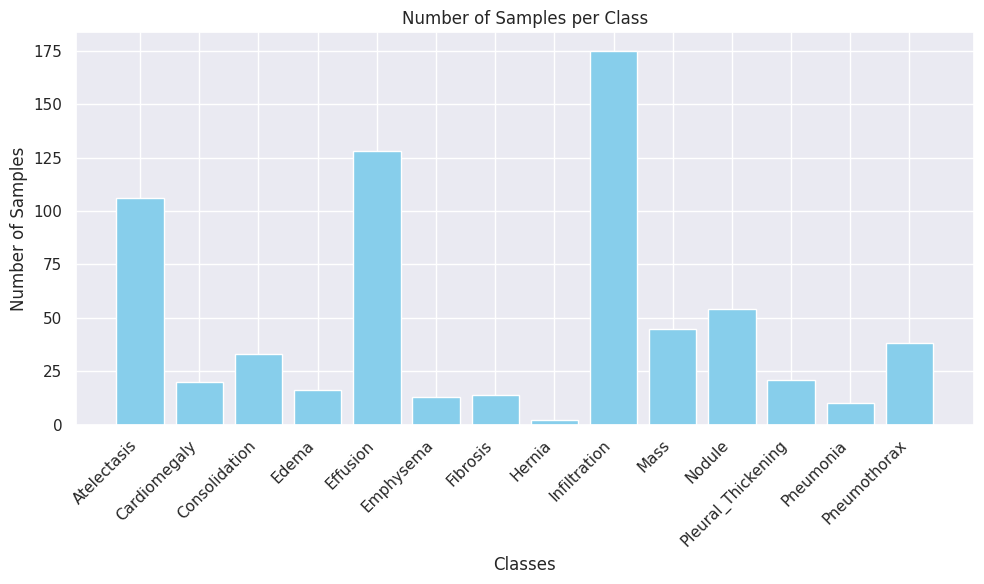

In [11]:
plt.figure(figsize=(10, 6))
plt.bar(columns, sum_column, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Yukarıdaki her bir sınıftaki etiketlerin sayılarına bir göz atın. Bu dengeli bir veri kümesine benziyor mu?**

**Cevap:** Sınıflardaki veri dağılımına bakıldığında dengesiz bir veri seti olduğunu görülmektedir. Örnek olarak Hernia, Emphysema, Fibrosis, Edema, Pneumonia ve Consolidation sınıfıların örnek sayıları 10-30 arasında iken Atelectasis Infiltration, Effusion sınıfların örnek sayıları 100'ün üzerinde olduğu görülmektedir. Veri seti  incelendiğinde sınıflar arası örnek sayılarının  aralarındaki farkın büyük olması sebebiyle veri setinin dengesiz olduğu anlaşılmaktadır.

# VERİ SETİNİN İÇERİSİNDEN 9 ADET RASTGELE GÖRÜNTÜ SEÇME

In [12]:
# Veri çerçevesindeki Görüntü sütunundan numpy değerlerini ayıklama
images = train_df['Image'].values
# İçinden 9 rastgele görüntü çıkarımı
random_images = [np.random.choice(images) for i in range(9)]
# Location of the image dir
img_dir = 'nih/images_small/'
print('Display Random Images')

# Kayıt edilecek dizini oluşturun
output_dir = 'random_images_output'
os.makedirs(output_dir, exist_ok=True)


Display Random Images


Kaydedilen Görüntülerin Detayları:
9 görüntü "random_images_output" klasörüne kaydedildi.


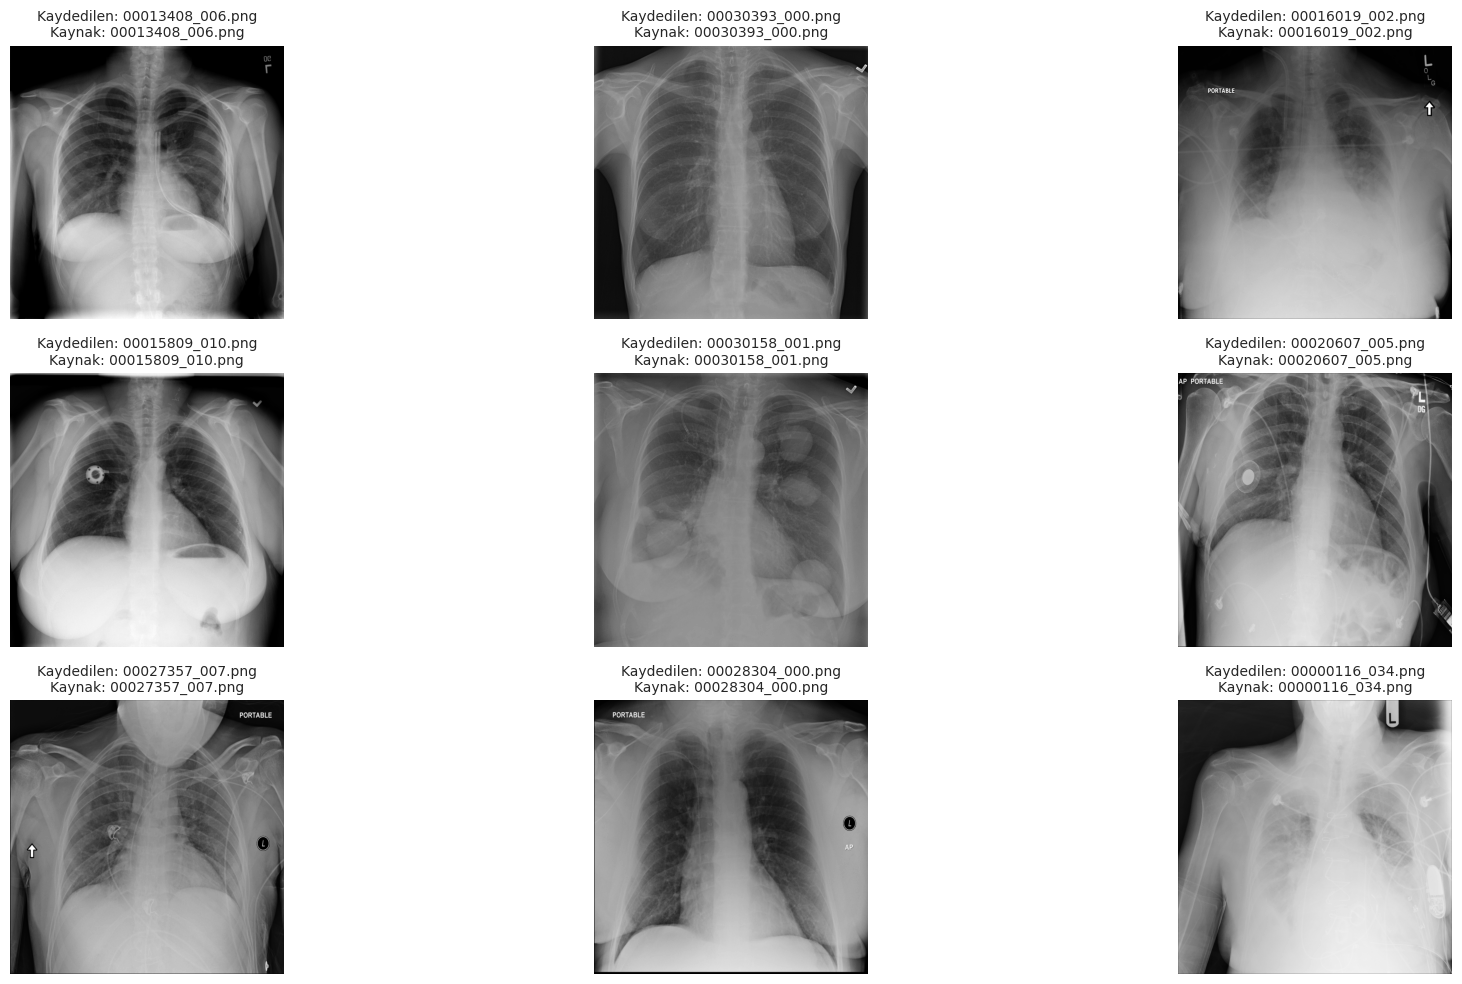

In [ ]:

# Veri çerçevesindeki Görüntü sütunundan numpy değerlerini ayıklama
images = train_df['Image'].values

# İçinden 9 rastgele görüntü çıkarımı
random_images = [np.random.choice(images) for i in range(9)]

# Görüntülerin bulunduğu dizin
img_dir = 'nih/images_small/'

# Kayıt edilecek dizini oluşturun
output_dir = 'random_images_output'
os.makedirs(output_dir, exist_ok=True)

# Görüntülerin gösterimi ve kaydedilmesi
plt.figure(figsize=(20, 10))
print("Kaydedilen Görüntülerin Detayları:")
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join(img_dir, random_images[i])
    img = Image.open(img_path).convert('L')  # Görüntüyü Pillow ile açtık ve gri tonlama yaptık

    # Görüntüyü matplotlib ile gösterme
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    # Görüntüyü Pillow ile kaydetme (DPI ve bit derinliği korunur)
    output_filename = f'{random_images[i]}'
    output_path = os.path.join(output_dir, output_filename)
    img.save(output_path)

    # Görüntünün başlığına kaydedilen isim ve kaynak ismi ekleme
    plt.title(f"Kaydedilen: {output_filename}\nKaynak: {random_images[i]}", fontsize=10)

print(f'{len(random_images)} görüntü "{output_dir}" klasörüne kaydedildi.')

# Gösterimi ayarlama ve tüm alt başlıkları daha okunabilir yapma
plt.tight_layout()
plt.show()


# RASTGELE SEÇİLEN 9 GÖRÜNTÜNÜN GÖSTERİMİ

Display Random Images


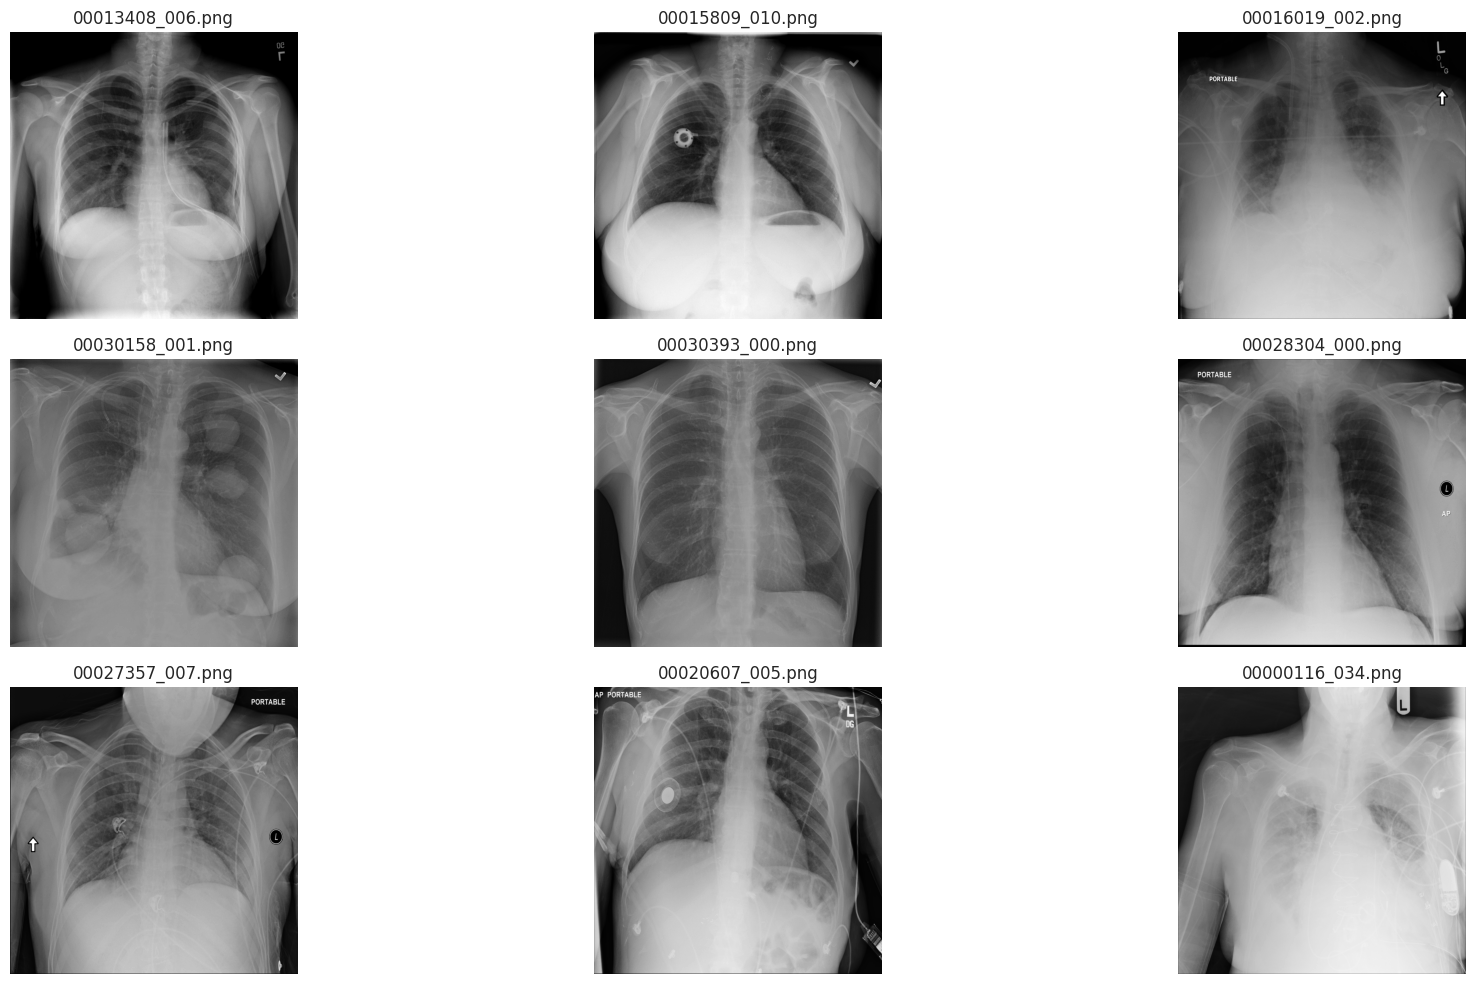

In [13]:
print('Display Random Images')

# Görsellerin bulunduğu klasör yolu
img_dir2 = '/content/drive/MyDrive/random_images_output'

# Klasördeki yalnızca görüntü dosyalarının isimlerini alıyoruz
all_images = [img for img in os.listdir(img_dir2) if os.path.isfile(os.path.join(img_dir2, img))]

# Adjust the size of your images
plt.figure(figsize=(20,10))
# Iterate and plot random images
for i in range(9):
  plt.subplot(3, 3, i + 1)
  img = plt.imread(os.path.join(img_dir2, all_images[i]))
  plt.imshow(img, cmap='gray')
  plt.title(all_images[i])
  plt.axis('off')

# Adjust subplot parameters to give specified padding
plt.tight_layout()


# RASTGELE SEÇİLEN 9 GÖRÜNTÜNÜN ISTATISTIKSEL ÖZELLİKLERİNİ (MAKSIMUM, MINIMUM, MEAN VE STD) HESAPLAMASI

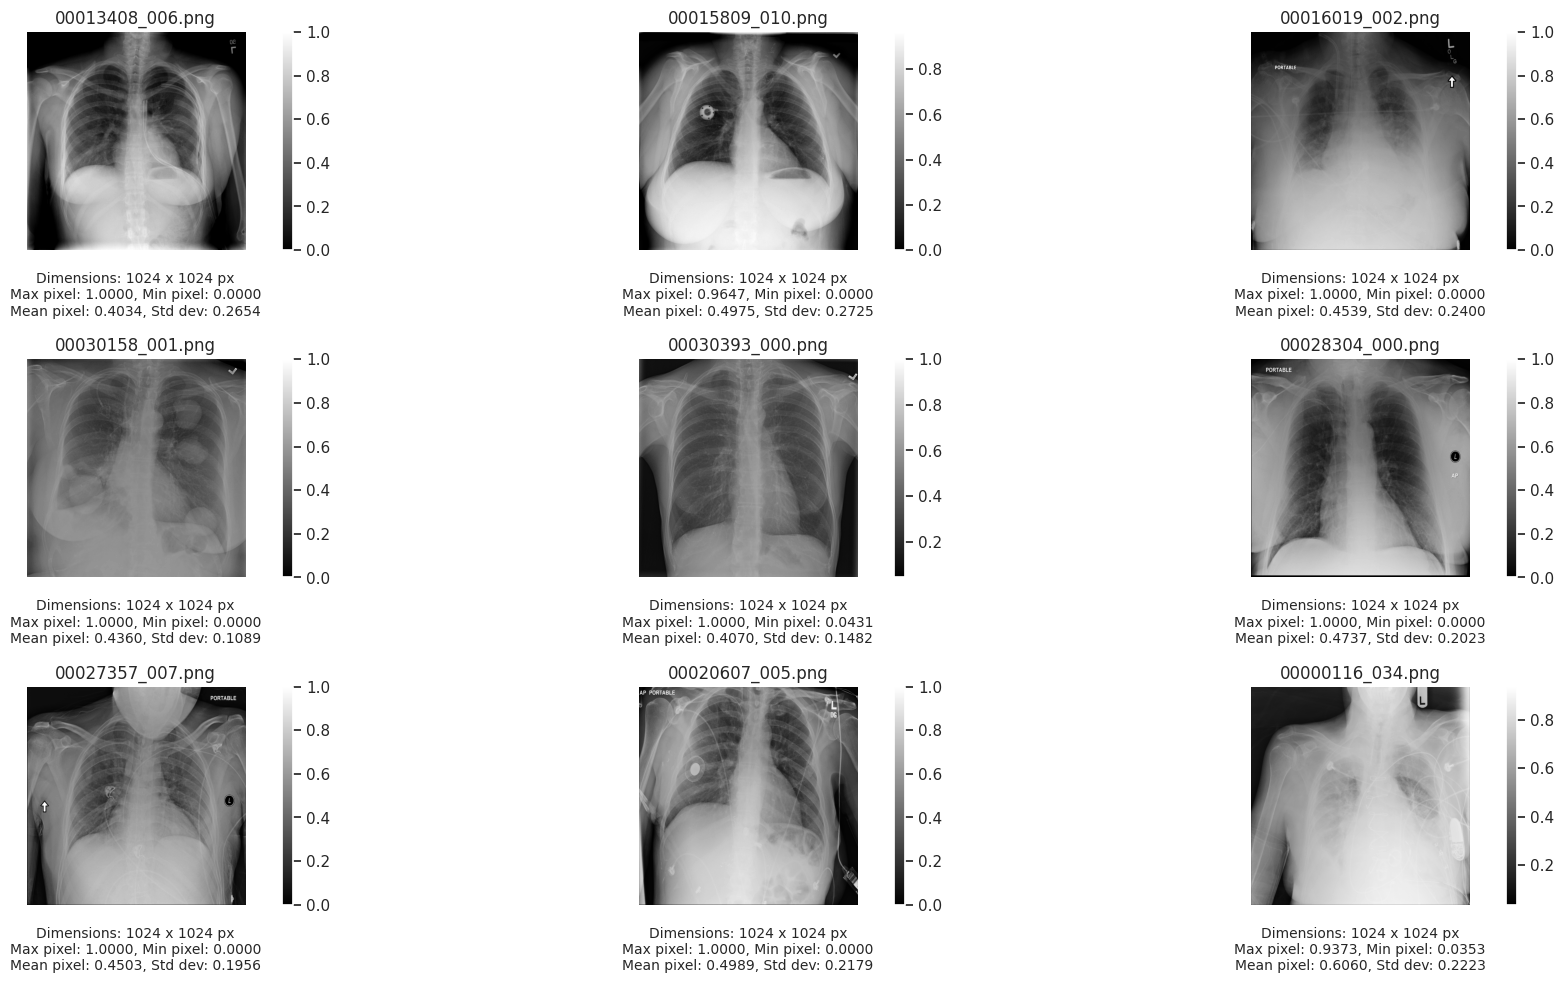

In [4]:
plt.figure(figsize=(20,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  img = plt.imread(os.path.join(img_dir2, all_images[i]))
  plt.imshow(img, cmap='gray')
  plt.colorbar()
  image_info = (
        f"Dimensions: {img.shape[0]} x {img.shape[1]} px\n"
        f"Max pixel: {img.max():.4f}, Min pixel: {img.min():.4f}\n"
        f"Mean pixel: {img.mean():.4f}, Std dev: {img.std():.4f}"
    )
  plt.text(0.5, -0.1, image_info, ha='center', va='top', fontsize=10,  transform=plt.gca().transAxes)


# Adjust subplot parameters to give specified padding
plt.tight_layout()

# RASTGELE SEÇİLEN 9 GÖRÜNTÜNÜN ISTATISTIKSEL ÖZELLİKLERİN İNCELENMESİ
  Rastgele seçilen 9 görüntünün piksel yoğunluğu ve standart sapmalarına bakıldığında aralarında en düşük standart sapma değerine sahip olan 30158_001 nolu görüntüdür. Görüntüdeki piksel değerleri birbirne oldukça  yakın ve düşük çeşitliliğe sahiptir. Standart sapma değeri en yüksek 15809_010 nolu görüntüdür ve diğerlerine göre piksel değerleri daha geniş bir aralığa yayılmış, farklılıklar belirgindir.

  Ortalama piksel yoğunluklarına baklıdığında en düşük ortalamaya sahip olan 13408_006 nolu görüntüdür. Bu görüntüde diğer görüntülere göre daha karanlık bölgelere sahipken ortalama piksel yoğunluğu yüksek olan 116_034 nolu görüntünün daha parlak bölgelere sahiptir. Bu durum, yoğun doku veya parlaklık veren nesneler nedeniyle oluşabilir.

# RASTGELE SEÇİLEN 9 GÖRÜNTÜNÜN PİKSEL YOĞUNLUKLARI VE STANDART SAPMA DEĞERLERİNİN HİSTOGRAM ÇİZİMİ

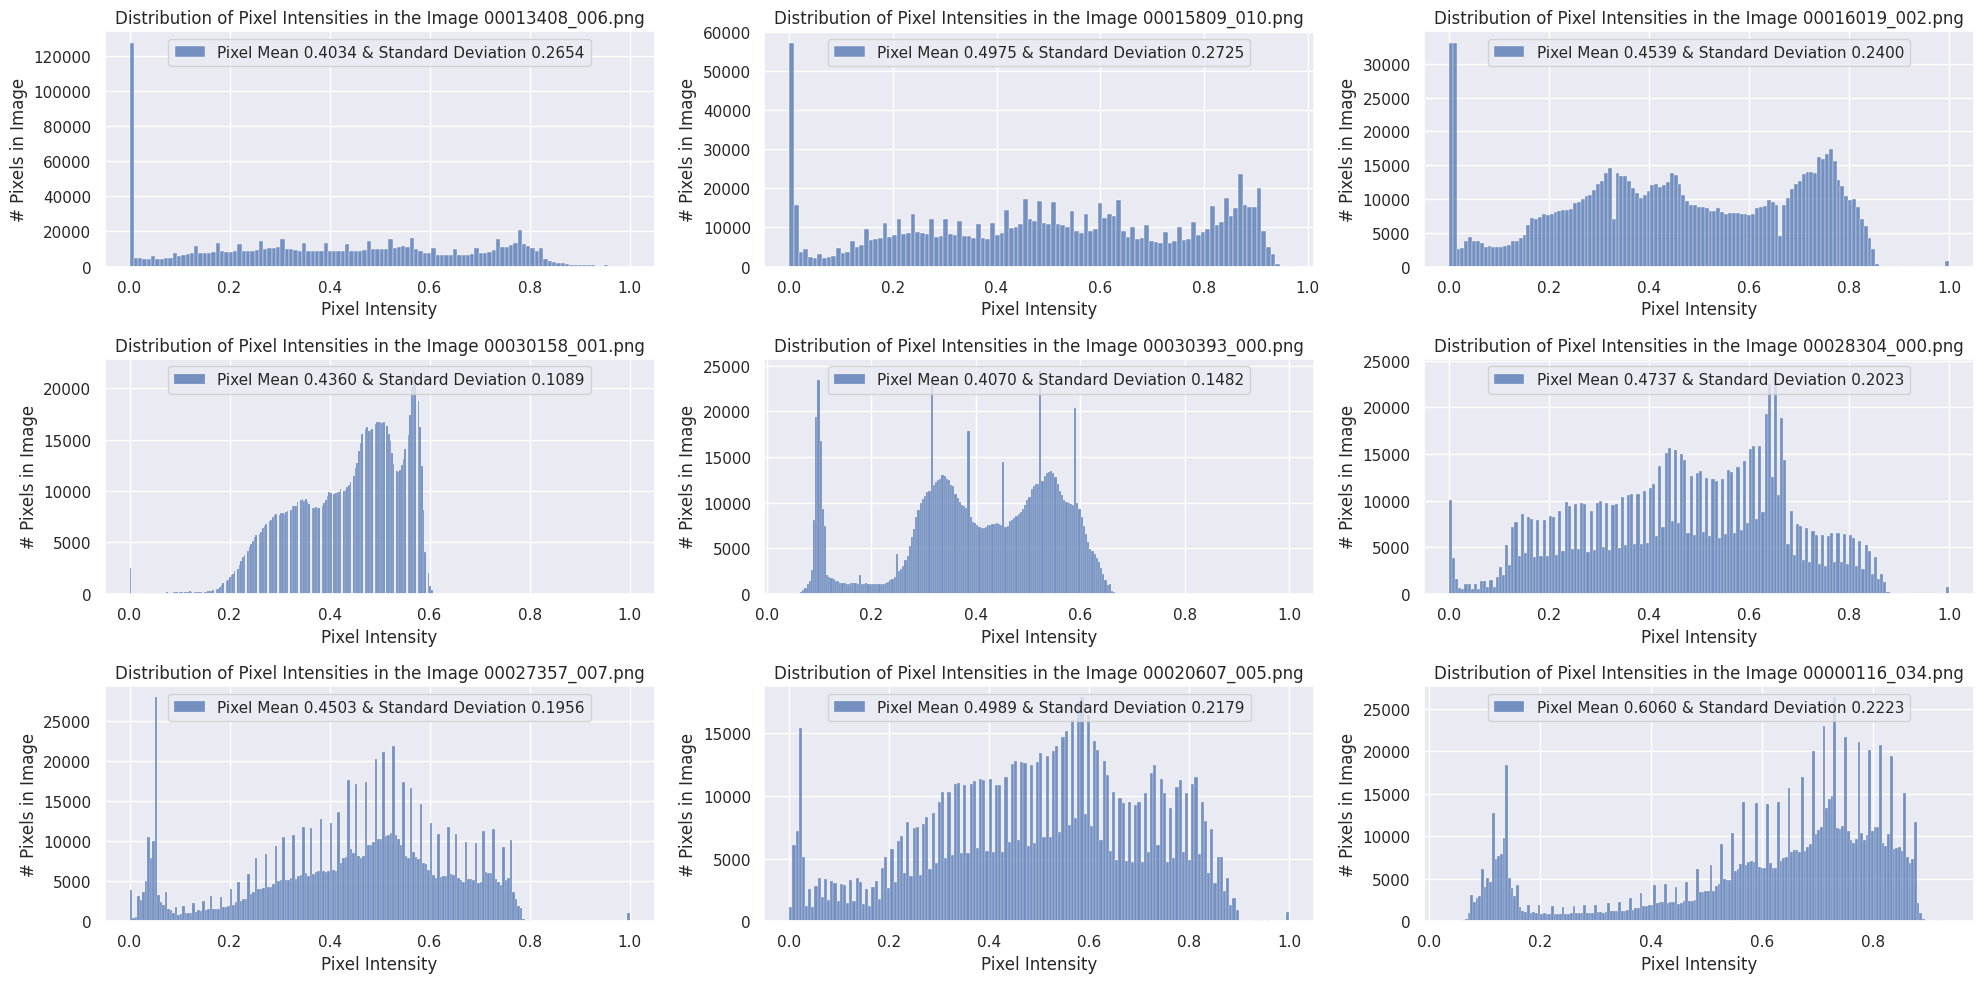

In [5]:
plt.figure(figsize=(20,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  img = plt.imread(os.path.join(img_dir2, all_images[i]))

  sns.histplot(img.ravel(),
             label=f'Pixel Mean {np.mean(img):.4f} & Standard Deviation {np.std(img):.4f}', kde=False)

  plt.legend(loc='upper center')
  plt.title(f'Distribution of Pixel Intensities in the Image {all_images[i]}')
  plt.xlabel('Pixel Intensity')
  plt.ylabel('# Pixels in Image')

  plt.ticklabel_format(axis='y', style='plain')

# Adjust subplot parameters to give specified padding
plt.tight_layout()

# ÇİZİLEN HİSTOGRAMLARIN DEĞERLENDİRİLMESİ

Görüntü segmentasyonu yapabilmek için piksel yoğunlukları ve standart sapma değerinin dağılımına bakılarak  ve görüntüdeki farklı yoğunluk seviyelerine dayalı olarak bölgeleri sınıflandırabilmek için bir threshold değeri seçiminde bize yol göstermektedir. Histogramdaki piksel yoğunluğunu  dağılımı inceleyerek histogramdaki 2 tepe nokta arasındaki alan farklı bölgeler arasındaki geçişleri temsil edebilir ve genellikle iyi bir threshold noktasıdır. Örnek olarak 30393_0 nolu görütünün histogramına bakıcak olursak threshold nokları 0.2 veya 0.5 olarak seçilebilir.

# RASTGELE SEÇİLEN 9 GÖRÜNTÜLERE  CONTRAST STRECTCHING , CONTRAST EQUALİZED VE GAMMA TRANSFORMATIONU UYGULAMA

In [6]:
gamma_corrected_images = []

for img_name in all_images[:9]:  # İlk 9 görüntü için
    img_path = os.path.join(img_dir2, img_name)
    raw_image = plt.imread(img_path)

    # Step 1: Kontrast germe
    min_val, max_val = raw_image.min(), raw_image.max()
    contrast_stretched = (raw_image - min_val) / (max_val - min_val)
    contrast_stretched = (contrast_stretched * 255).astype(np.uint8)

    # Step 2: Histogram eşitleme
    equalized_image = exposure.equalize_hist(contrast_stretched)
    equalized_image = (equalized_image * 255).astype(np.uint8)

    # Step 3: Gama düzeltme
    gamma = 1.6
    gamma_corrected = np.power(equalized_image / 255.0, gamma) * 255
    gamma_corrected = gamma_corrected.astype(np.uint8)

    gamma_corrected_images.append(gamma_corrected)

    # Görüntü ve histogramları gösterme
    plt.figure(figsize=(18, 10))

    # Orijinal Görüntü ve Histogram
    plt.subplot(2, 4, 1)
    plt.imshow(raw_image, cmap='gray')
    plt.title(f'Original Image - {img_name}')
    plt.colorbar()
    plt.subplot(2, 4, 5)
    plt.hist(raw_image.ravel(), bins=256, color='gray')
    plt.title("Original Image Histogram")

    # Kontrast Gerilmiş Görüntü ve Histogram
    plt.subplot(2, 4, 2)
    plt.imshow(contrast_stretched, cmap='gray')
    plt.title('Contrast-Stretched Image')
    plt.colorbar()
    plt.subplot(2, 4, 6)
    plt.hist(contrast_stretched.ravel(), bins=256, color='gray')
    plt.title("Contrast-Stretched Histogram")

    # Histogram Eşitlenmiş Görüntü ve Histogram
    plt.subplot(2, 4, 3)
    plt.imshow(equalized_image, cmap='gray')
    plt.title('Contrast Equalized Image')
    plt.colorbar()
    plt.subplot(2, 4, 7)
    plt.hist(equalized_image.ravel(), bins=256, color='gray')
    plt.title("Equalized Histogram")

    # Gama Düzeltme Görüntü ve Histogram
    plt.subplot(2, 4, 4)
    plt.imshow(gamma_corrected, cmap='gray')
    plt.title(f'Gamma-Corrected Image (Gamma={gamma})')
    plt.colorbar()
    plt.subplot(2, 4, 8)
    plt.hist(gamma_corrected.ravel(), bins=256, color='gray')
    plt.title("Gamma-Corrected Histogram")

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# CONTRAST STRECTCHING , CONTRAST EQUALİZED VE GAMMA TRANSFORMATIONU UYGULANMIŞ BİR GÖRÜNTÜNÜN DEĞERLENDİRİLMESİ

27357_007 nolu görüntünün **Contrast Sreched** uygulanarak görüntüde karalık ve parlak alanların belirgin hale geldiğini görünmektedir. **Contrast Equalized** uygulandığında görüntünün genel kontrastı iyileştiğini ve düşük ışık koşulları ve düşük kontrastlı alanların detayları arttığı görülmektedir. **Gamma Corrected** uygulandığında ise gamma değeri 1.2 seçildiğinde belirli parlaklık seviyelerin daha görünür olduğu görülmektedir. gamma değerini 1.6 seçildiğinde çok parlak alanların daha belirgin hale geldiğini ama düşük parlaklığa sahip olan alanların kaybolmasına neden olmaktadır.

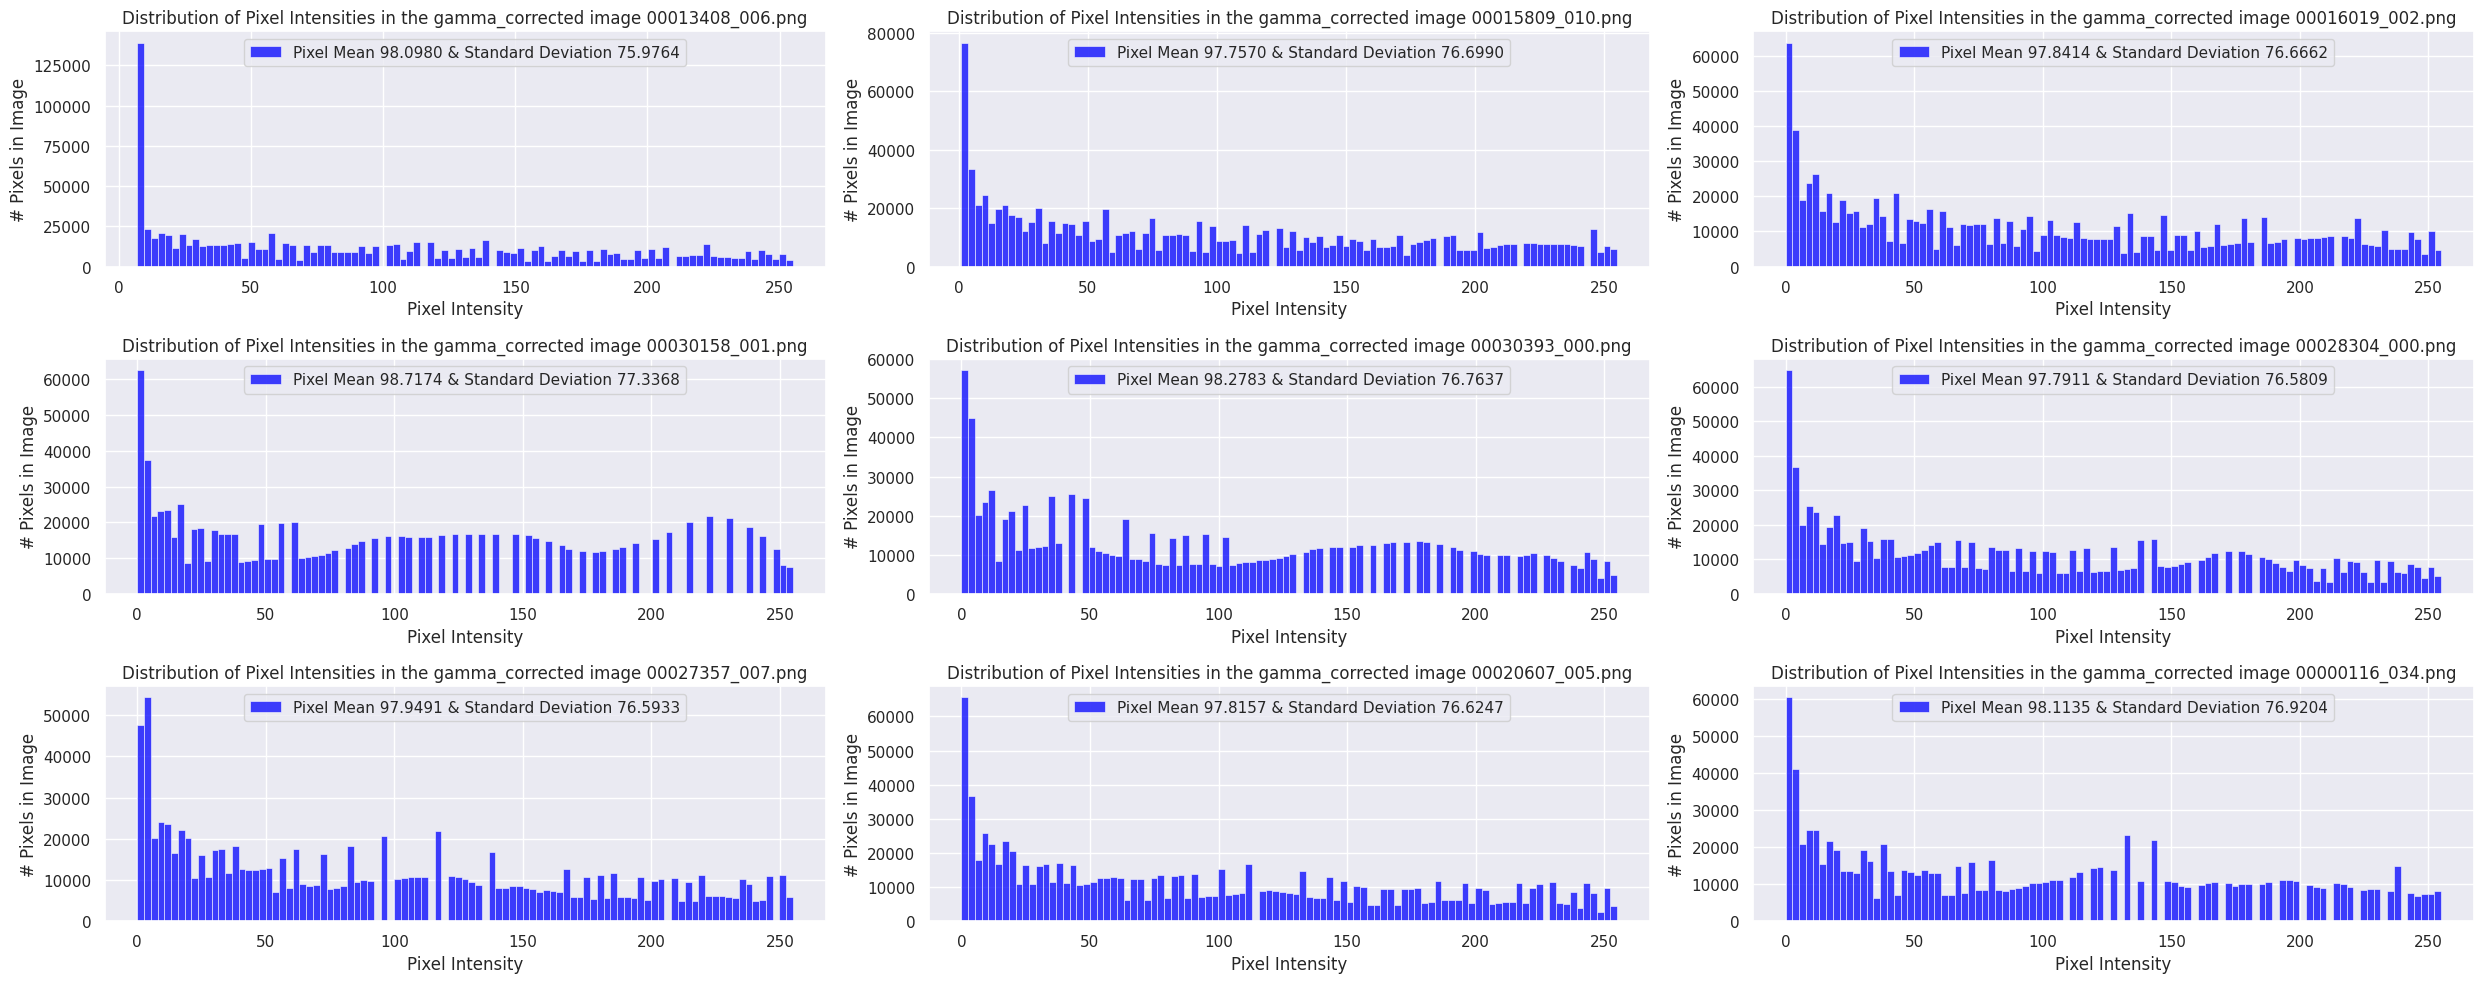

In [7]:

# Histogramları 3x3 matris şeklinde göstermek için figür oluşturuyoruz
plt.figure(figsize=(25, 10))

for idx, gamma_corrected in enumerate(gamma_corrected_images):  # Her görüntü ve indeks için döngü
    plt.subplot(3, 3, idx + 1)  # 3x3 düzeninde her histogram için bir alt grafik

    # Histogram çizimi
    sns.histplot(
        gamma_corrected.ravel(),
        label=f'Pixel Mean {np.mean(gamma_corrected):.4f} & Standard Deviation {np.std(gamma_corrected):.4f}',
        kde=False,
        color="blue"
    )

    # Başlık ve etiketler
    plt.legend(loc='upper center')
    plt.title(f'Distribution of Pixel Intensities in the gamma_corrected image {all_images[idx]}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('# Pixels in Image')

    # Y ekseni biçimini düz metin olarak ayarlama
    plt.ticklabel_format(axis='y', style='plain')

# Alt grafiklerin düzenini ayarlıyoruz
plt.tight_layout()
plt.show()


# Gamma Uygulanan Resimlerin Histogram Yorumu

Piksel yoğunlukları daha geniş bir aralığa yayıldığı görülmektedir. Standart sapma değerleri 75-76 arasındadır. Bu, görüntüdeki parlaklık değerlerinin geniş bir yelpazeye yayıldığını ve gamma düzeltmesinin farklı yoğunluk seviyelerini belirgin hale getirdiği görülmektedir.

# Median ve Gaussian Filterın Uygulanması

In [8]:
Median_filtered_images = []

# İlk 9 gamma uygulanmış görüntü için medyan ve Gauss bulanıklığı uygulanmış halleri göstermek için
for idx, gamma_corrected in enumerate(gamma_corrected_images[:9]):  # İlk 9 görüntü için döngü
    # Medyan Filtreleme
    median_filtered = cv2.medianBlur(gamma_corrected, 5)
    # Gauss Bulanıklığı
    gaussian_filtered = cv2.GaussianBlur(gamma_corrected, (5, 5), 0)

    Median_filtered_images.append(median_filtered)

    # Her görüntü için 2x2 matris şeklinde bir figür oluşturuyoruz
    plt.figure(figsize=(10, 10))

    # Medyan Filtrelenmiş Görüntü
    plt.subplot(2, 2, 1)
    plt.imshow(median_filtered, cmap='gray')
    plt.title("Median Filtered Image")
    plt.axis('off')

    # Gauss Bulanıklığı Uygulanmış Görüntü
    plt.subplot(2, 2, 2)
    plt.imshow(gaussian_filtered, cmap='gray')
    plt.title("Gaussian Filtered Image")
    plt.axis('off')


    plt.suptitle(f"Filtered Results for Image {all_images[idx]}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Başlığın çakışmaması için düzenleme
    plt.show()




Output hidden; open in https://colab.research.google.com to view.

# Median ve Gaussian Filterın Uygulanan Görüntülerin Yorumu
  15809_010 median filtre uygulanmış görüntüde gürültü büyük ölçüde temizlenmiş ve kenarlar belirgin bir şekilde korunmuş durumda. Özellikle, göğüs kafesi çevresindeki detaylar keskinliğini korurken, organ sınırları net bir şekilde seçilebilmektedir.
  Gaussian filtre uygulanan görüntü de ise genel olarak daha yumuşak bir hale gelmiş, ancak detaylarda hafif bir bulanıklık meydana gelmiştir. Örneğin, sol taraftaki yuvarlak metalik yapı Gaussian filtre sonucunda daha az belirgin hale gelmiştir.

  Median filtre, detayların korunması açısından daha başarılı bir sonuç sunarken; Gaussian filtre, genel gürültü azaltımı ve yumuşatma için daha uygun bir seçenek olmuştur. Ekteki görüntülerde, Median filtre daha keskin detaylar sunarken, Gaussian filtre ile daha düz ve pürüzsüz bir görüntü elde edilmiştir. Görüntülerin kullanım amacına bağlı olarak bu iki yöntem arasında tercih yapılabilir.

# Rotation ve Horizontally Filterın Uygulanması

In [9]:

rotation_corrected_images = []
# İlk 9 gamma uygulanmış görüntüye rastgele döndürme ve yatay çevirme işlemi uygulama
for idx, median_corrected in enumerate(Median_filtered_images[:9]):  # İlk 9 görüntü için


    # Rastgele bir açı seç (0 ila 10 derece arasında)
    angle = idx + 1

    # Görüntü merkezini belirleyip döndürme matrisini oluşturuyoruz
    center = (median_corrected.shape[1] // 2, median_corrected.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle=angle, scale=1.0)
    rotated_image = cv2.warpAffine(median_corrected, rotation_matrix, (median_corrected.shape[1], median_corrected.shape[0]))
    rotation_corrected_images.append(rotated_image)
    # Yatay çevirme işlemi
    flipped_horizontal = cv2.flip(median_corrected, 1)

    # Her görüntü için 2x2 matris şeklinde bir figür oluşturuyoruz
    plt.figure(figsize=(10, 10))


    # Rastgele döndürülmüş görüntü
    plt.subplot(2, 2, 1)
    plt.imshow(rotated_image, cmap='gray')
    plt.title(f"Rotated Image (Angle={angle:.2f}°)")
    plt.axis('off')

    # Yatay çevrilmiş görüntü
    plt.subplot(2, 2, 2)
    plt.imshow(flipped_horizontal, cmap='gray')
    plt.title("Horizontally Flipped Image")
    plt.axis('off')

    plt.suptitle(f"Transformations for Image {all_images[idx]}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Başlık çakışmasını önlemek için ayarlama
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# **Rotation ve Horizontally Filter Uygulanan Görüntülerin Yorumu**

Döndürme işlemleri, görüntü üzerindeki yapıları korurken, çerçeve kenarlarında siyah alanlar oluşturmuştur. Bu alanlar veri kaybına neden olabilir ve modele doğru bilgi sağlanması için ek işlem adımları (örneğin, kırpma veya doldurma) gerekebilir.

Yatay çevirme işlemi, simetrik varyasyonlar oluşturmuş ancak organların pozisyonunu değiştirdiği için tıbbi bağlamda dikkatli bir şekilde değerlendirilmelidir.

# Frequency Domain Filtered Uygulanması

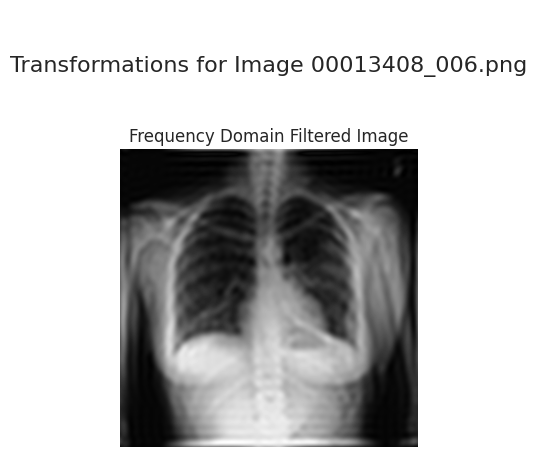

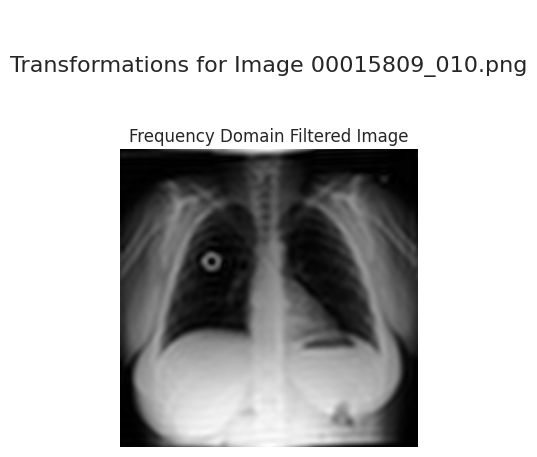

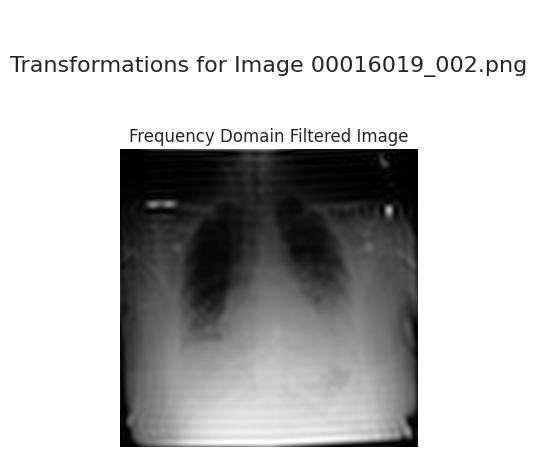

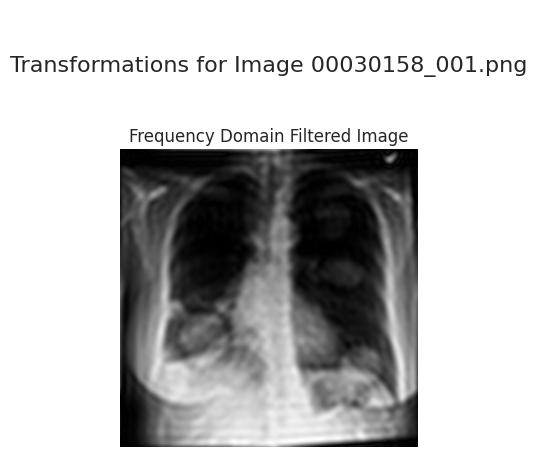

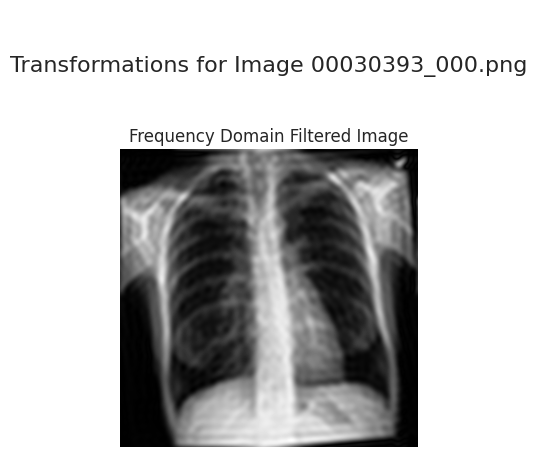

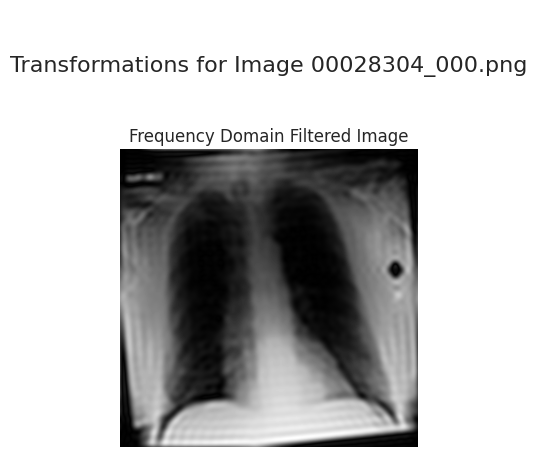

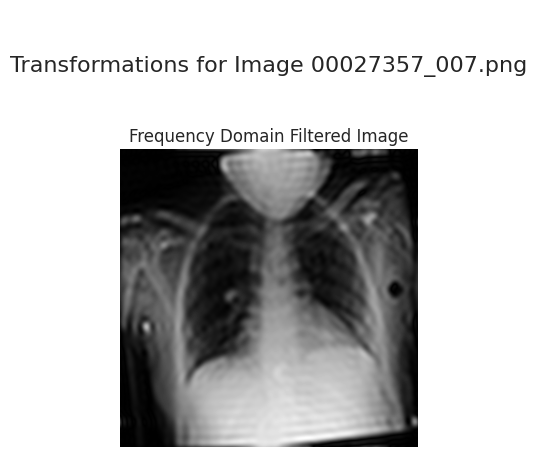

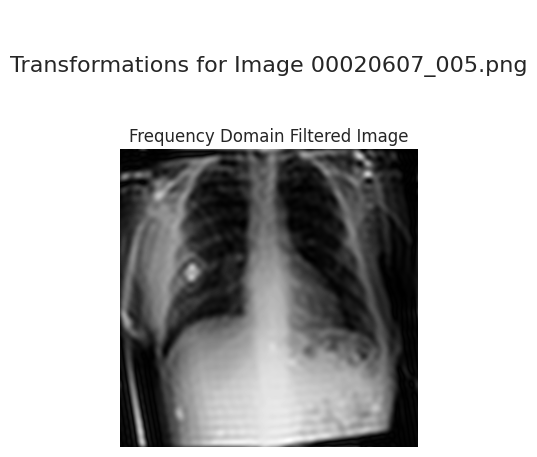

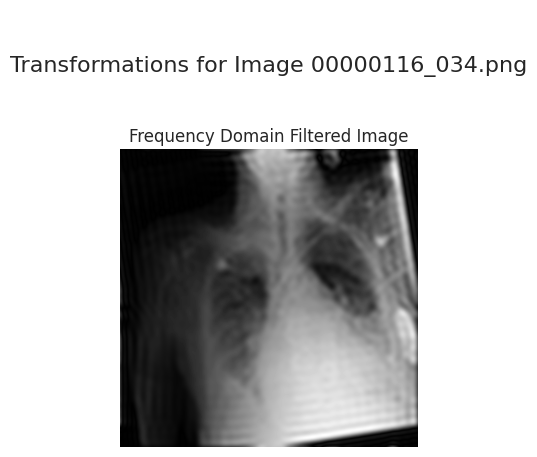

In [15]:
for idx, rotation_corrected in enumerate(rotation_corrected_images[:9]):    # İlk 9 görüntü için

    # Apply Fourier Transform and shift it to center low frequencies
    dft = cv2.dft(np.float32(rotation_corrected), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)

  # Create a mask for filtering
    rows, cols = rotation_corrected.shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.zeros((rows, cols, 2), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1  # Center low frequencies pass

    # Apply mask and inverse DFT
    fshift = dft_shifted * mask
    f_ishift = np.fft.ifftshift(fshift)
    filtered_image = cv2.idft(f_ishift)
    filtered_image = cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])

    # Normalize and display the filtered image
    filtered_image = cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX)
    plt.imshow(filtered_image, cmap='gray')
    plt.title(f"Frequency Domain Filtered Image")
    plt.axis("off")
    plt.suptitle(f"\n\nTransformations for Image {all_images[idx]}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Başlık çakışmasını önlemek için ayarlama
    plt.show()

**# Frequency Domain filtre uygulanan Görüntülerin Yorumu**

 28304_000 görüntüde, üzerinde frekans filtresi uygulanarak, akciğerlerin ve omurga gibi yapısal detayların netliği artırılmıştır. Düşük frekanslı alanlar  bastırılmış ve yüksek frekanslı bileşenler öne çıkarılmıştır. Bu sayede özellikle kemik yapıları daha görünür hale gelmiştir.

 27357_007 görüntüde ise benzer şekilde detayları vurgulamış ve kontrastı artırmıştır.Akciğerler arasındaki boşluk ve metalik implantın bulunduğu bölgedeki keskinlik artmıştır.



# **Görüntülere Sharpened ve Interpolated Uygulanması**

In [11]:
for idx, gamma_corrected in enumerate(gamma_corrected_images[:9]):

  # İlk 9 görüntü için

  sharpening_kernel = np.array([[-1, -1, -1],
                              [-1,  9, -1],
                              [-1, -1, -1]])
  sharpened_image = np.clip(cv2.filter2D(gamma_corrected, -1, sharpening_kernel), 0, 255).astype(np.uint8)

  # Step 5: Apply bicubic interpolation to upscale the image by a factor of 2
  scale_factor = 2
  resized_image = zoom(sharpened_image, scale_factor, order=3)  # Bicubic interpolation with `order=3`

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1), plt.imshow(sharpened_image, cmap='gray'),plt.title("Sharpened Image")
  plt.subplot(1, 2, 2), plt.imshow(resized_image, cmap='gray'),plt.title("Interpolated (Upscaled) Image")


  plt.suptitle(f"Transformations for Image {all_images[idx]}", fontsize=16)
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Başlık çakışmasını önlemek için ayarlama
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

# **Görüntülere Sharpened ve Interpolated Uygulanmasının Yorumu**

13408_006 nolu görüntüye sharpened uygulandığında üzerindeki ince detaylar örneğin, akciğer ve kemik yapıları daha net bir şekilde ortaya çıkmıştır. Görüntünün kontrastı artırılmış, böylece organ sınırları ve olası patolojik bölgeler daha belirgin hale gelmiştir. Interpolasyon uygulandığında görüntünün çözünürlüğü artırılmış, bu da detayların daha geniş bir perspektifte incelenebilmesini sağlamıştır.


